In [102]:


import pathlib as p
from preprocessing import split_dataset, scale_to_reference_img, pad_to_shape, normalize, get_patches, reconstruct_from_patches, create_LR_img_simple
from evaluations import calculate_metrics
import nibabel as nib

# interpolated
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(DATA_DIR.rglob("*T2w_LR.nii.gz"))

patch_size = (64, 64, 64)
stride = (32, 32, 32)
target_shape = (192, 224, 192)  

files = list(zip(t1_files, t2_files, t2_LR_files))
train, val, test = split_dataset(files)
ref_img = nib.load(str(t1_files[0]))


In [103]:

train_t1, train_t2, train_t2_LR = get_patches(train, patch_size, stride, target_shape, ref_img)
val_t1, val_t2, val_t2_LR = get_patches(val, patch_size, stride, target_shape, ref_img)
test_t1, test_t2, test_t2_LR = get_patches(test, patch_size, stride, target_shape, ref_img)


real_images = []
interpolated_images = []



Control T2 shape: (182, 218, 182)
Control T2_LR shape: (182, 218, 182)


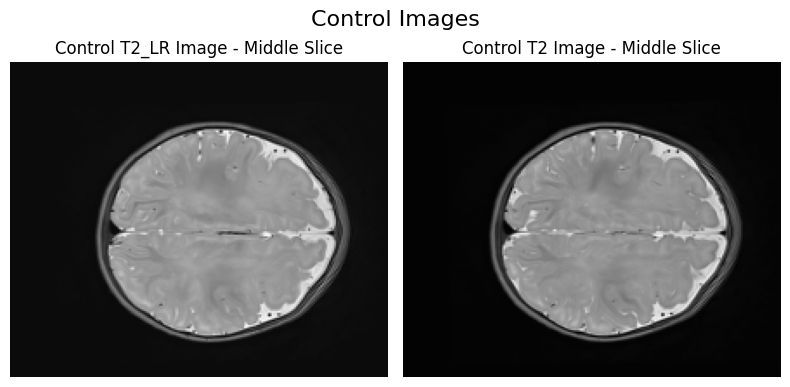

In [78]:
#control interpolated images

control_t2_img = nib.load(test[0][1]).get_fdata()
control_t2_LR_img = nib.load(test[0][2]).get_fdata()
print("Control T2 shape:", control_t2_img.shape)
print("Control T2_LR shape:", control_t2_LR_img.shape)
import matplotlib.pyplot as plt
#plot 2 axial slices of lr image
mid_slice = control_t2_LR_img.shape[1] // 2
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(control_t2_LR_img[:, :, 97], cmap='gray')
plt.axis('off')
plt.title("Control T2_LR Image - Middle Slice")
plt.subplot(1, 2, 2)
plt.imshow(control_t2_LR_img[:, :, 97+1], cmap='gray')
plt.axis('off')
plt.title("Control T2 Image - Middle Slice")
plt.suptitle('Control Images', fontsize=16)
plt.tight_layout()
plt.show()



Control T2 shape: (192, 224, 192)
Control T2_LR shape: (192, 224, 192)


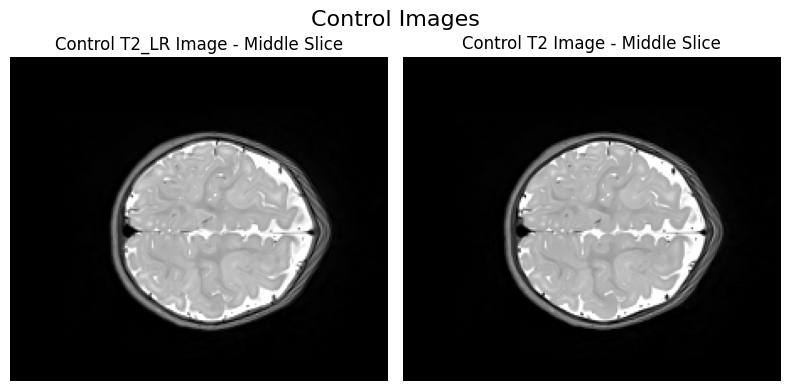

In [75]:
control_t2_img = real_images[0]
control_t2_LR_img = interpolated_images[0]
print("Control T2 shape:", control_t2_img.shape)
print("Control T2_LR shape:", control_t2_LR_img.shape)
import matplotlib.pyplot as plt
#plot 2 axial slices of lr image
mid_slice = control_t2_LR_img.shape[1] // 2
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(control_t2_LR_img[:, :, mid_slice+3], cmap='gray')
plt.axis('off')
plt.title("Control T2_LR Image - Middle Slice")
plt.subplot(1, 2, 2)
plt.imshow(control_t2_img[:, :, mid_slice+3], cmap='gray')
plt.axis('off')
plt.title("Control T2 Image - Middle Slice")
plt.suptitle('Control Images', fontsize=16)
plt.tight_layout()
plt.show()


In [94]:

real_images = []
interpolated_images = []
for t1_file, t2_file, t2_LR_file in test:
    #scaling to reference image
    t2_img = scale_to_reference_img(nib.load(t2_file), ref_img)
    t2_LR_img = scale_to_reference_img(nib.load(t2_LR_file), ref_img)
    #padding to be divisible by patch size
    t2_img = pad_to_shape(t2_img, target_shape)
    t2_LR_img = pad_to_shape(t2_LR_img, target_shape)
    #normalizing
    t2_img = normalize(t2_img)
    t2_LR_img = normalize(t2_LR_img)
    #add patches
    interpolated_images.append(t2_LR_img.get_fdata())
    real_images.append(t2_img.get_fdata())

metrics = calculate_metrics(real_images, interpolated_images)
print(f"Interpolated - PSNR: {metrics['psnr']}, SSIM: {metrics['ssim']}, NRMSE: {metrics['nrmse']}, MSE: {metrics['mse']}")


Interpolated - PSNR: 32.79298951752326, SSIM: 0.9835635009473741, NRMSE: 0.08685311590845989, MSE: 0.0005359069190869209


In [ ]:

#plot the middle slice of all images in a grid
import matplotlib.pyplot as plt
import numpy as np
num_images = len(real_images)
cols = 4
rows = num_images // cols + int(num_images % cols > 0)
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    mid_slice = real_images[i].shape[2] // 2
    plt.imshow(real_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Real Image {i+1}")
plt.suptitle('Real Images - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()



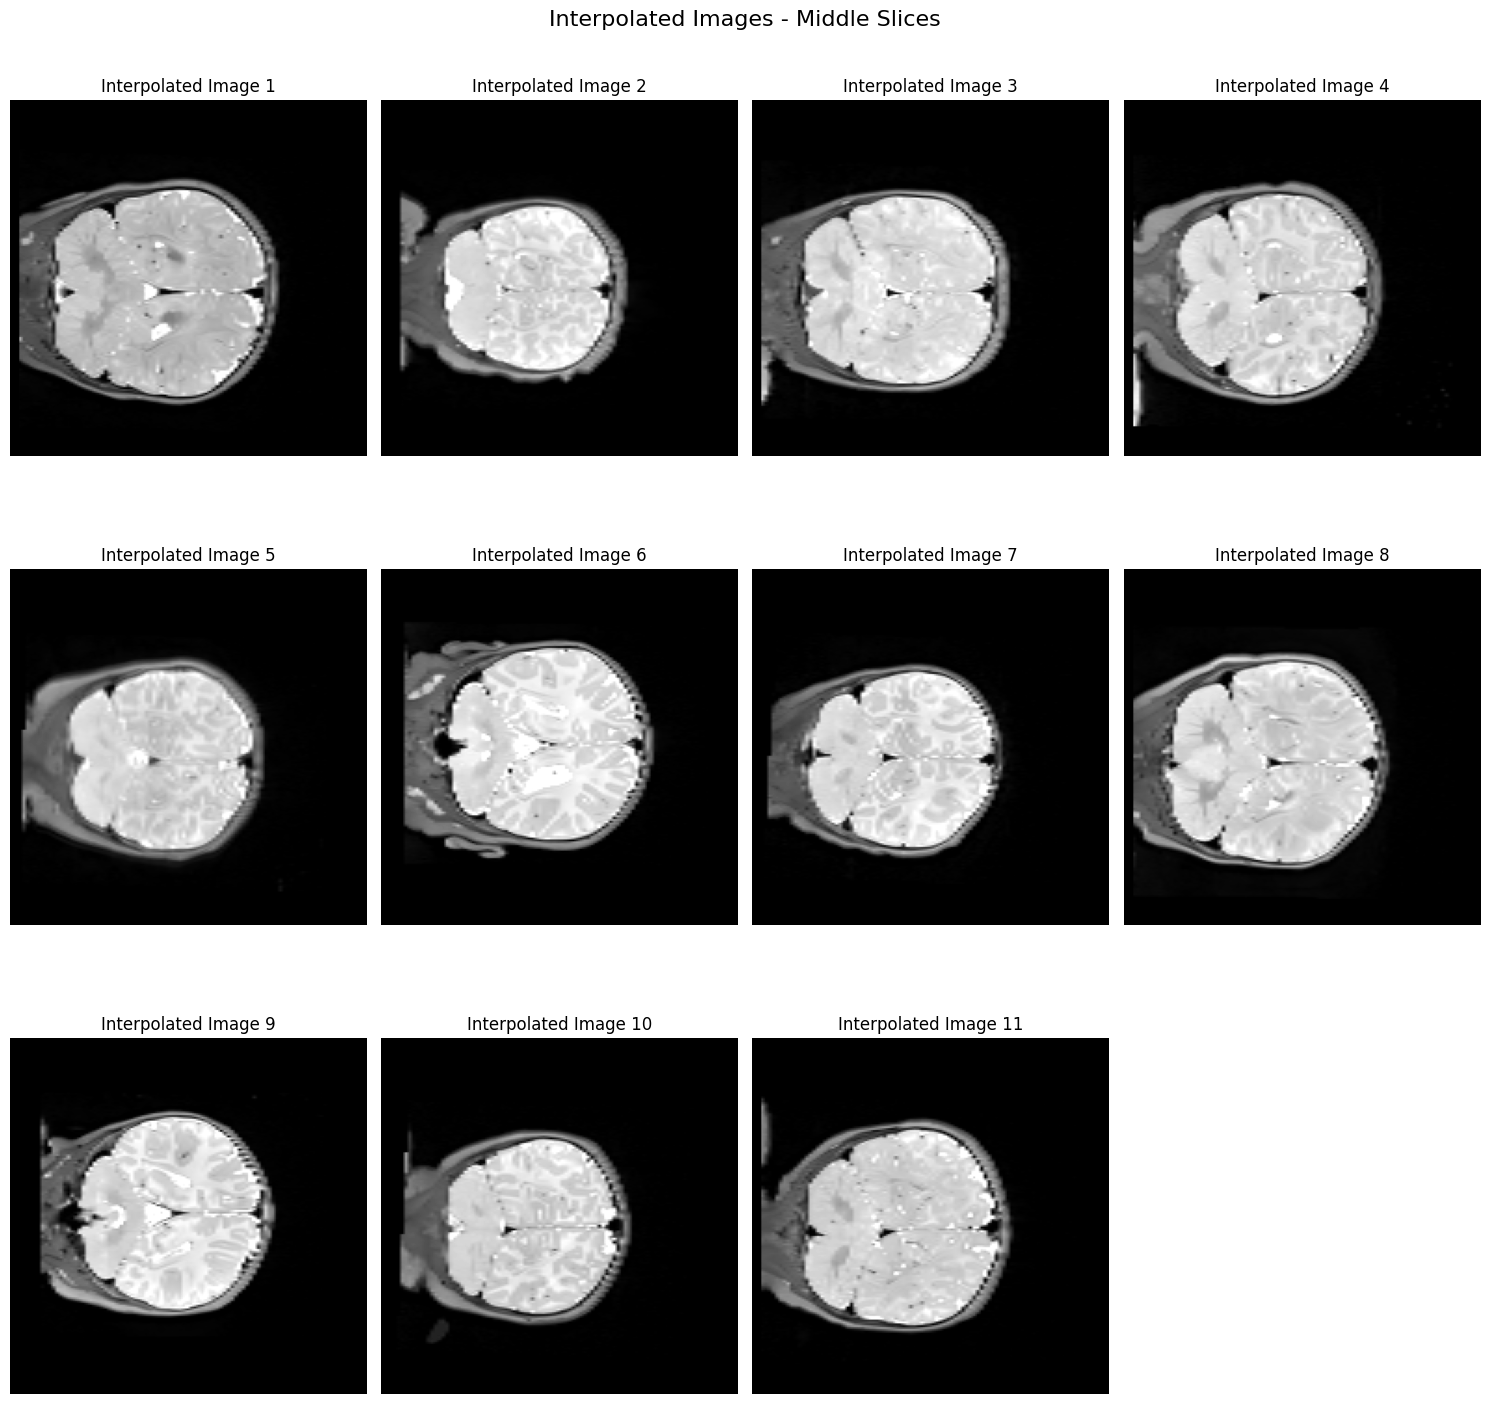

In [80]:

#same for interpolated images
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    mid_slice = interpolated_images[i].shape[2] // 2
    plt.imshow(interpolated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Interpolated Image {i+1}")
plt.suptitle('Interpolated Images - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()




In [ ]:
#IMAGE RECONSTRUCTION

#load Unet weights
import torch
from monai.networks.nets import UNet
DATA_DIR = p.Path.home()/"data"/"bobsrepository"

net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=None,
)
net.load_state_dict(torch.load(DATA_DIR/"outputs"/"GAN"/"2025-10-10T11:33:58.619837_model_weights.pth", map_location="cpu"))

generated_images = []

net.eval()
with torch.no_grad():
    for i in range(len(test_t1)):
        all_outputs = []
        for j in range(len(test_t1[0])):
            input1 = torch.tensor(test_t1[i][j]).float()
            input2 = torch.tensor(test_t2_LR[i][j]).float()
            inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)  # (1, 2, 64, 64, 64)
            output = net(inputs)
            all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (64, 64, 64)
        gen_reconstructed = reconstruct_from_patches(all_outputs, target_shape, stride)
        real_reconstructed = reconstruct_from_patches(test_t2[i], target_shape, stride)
        generated_images.append(gen_reconstructed)
        real_images.append(real_reconstructed)
        print(f"Processed test image {i+1}/{len(test_t1)}")



Processed test image 1/11
Processed test image 2/11
Processed test image 3/11
Processed test image 4/11
Processed test image 5/11
Processed test image 6/11
Processed test image 7/11
Processed test image 8/11
Processed test image 9/11
Processed test image 10/11
Processed test image 11/11


In [16]:
interpolated_images = []
for i in range(len(test_t1)):
        
        interpolated_reconstructed = reconstruct_from_patches(test_t2_LR[i], target_shape, stride)
        interpolated_images.append(interpolated_reconstructed)
        print(f"Processed test image {i+1}/{len(test_t1)}")

real_images = []
for i in range(len(test_t2)):
        
        real_reconstructed = reconstruct_from_patches(test_t2[i], target_shape, stride)
        real_images.append(real_reconstructed)
        print(f"Processed test image {i+1}/{len(test_t1)}")

Processed test image 1/11
Processed test image 2/11
Processed test image 3/11
Processed test image 4/11
Processed test image 5/11
Processed test image 6/11
Processed test image 7/11
Processed test image 8/11
Processed test image 9/11
Processed test image 10/11
Processed test image 11/11
Processed test image 1/11
Processed test image 2/11
Processed test image 3/11
Processed test image 4/11
Processed test image 5/11
Processed test image 6/11
Processed test image 7/11
Processed test image 8/11
Processed test image 9/11
Processed test image 10/11
Processed test image 11/11


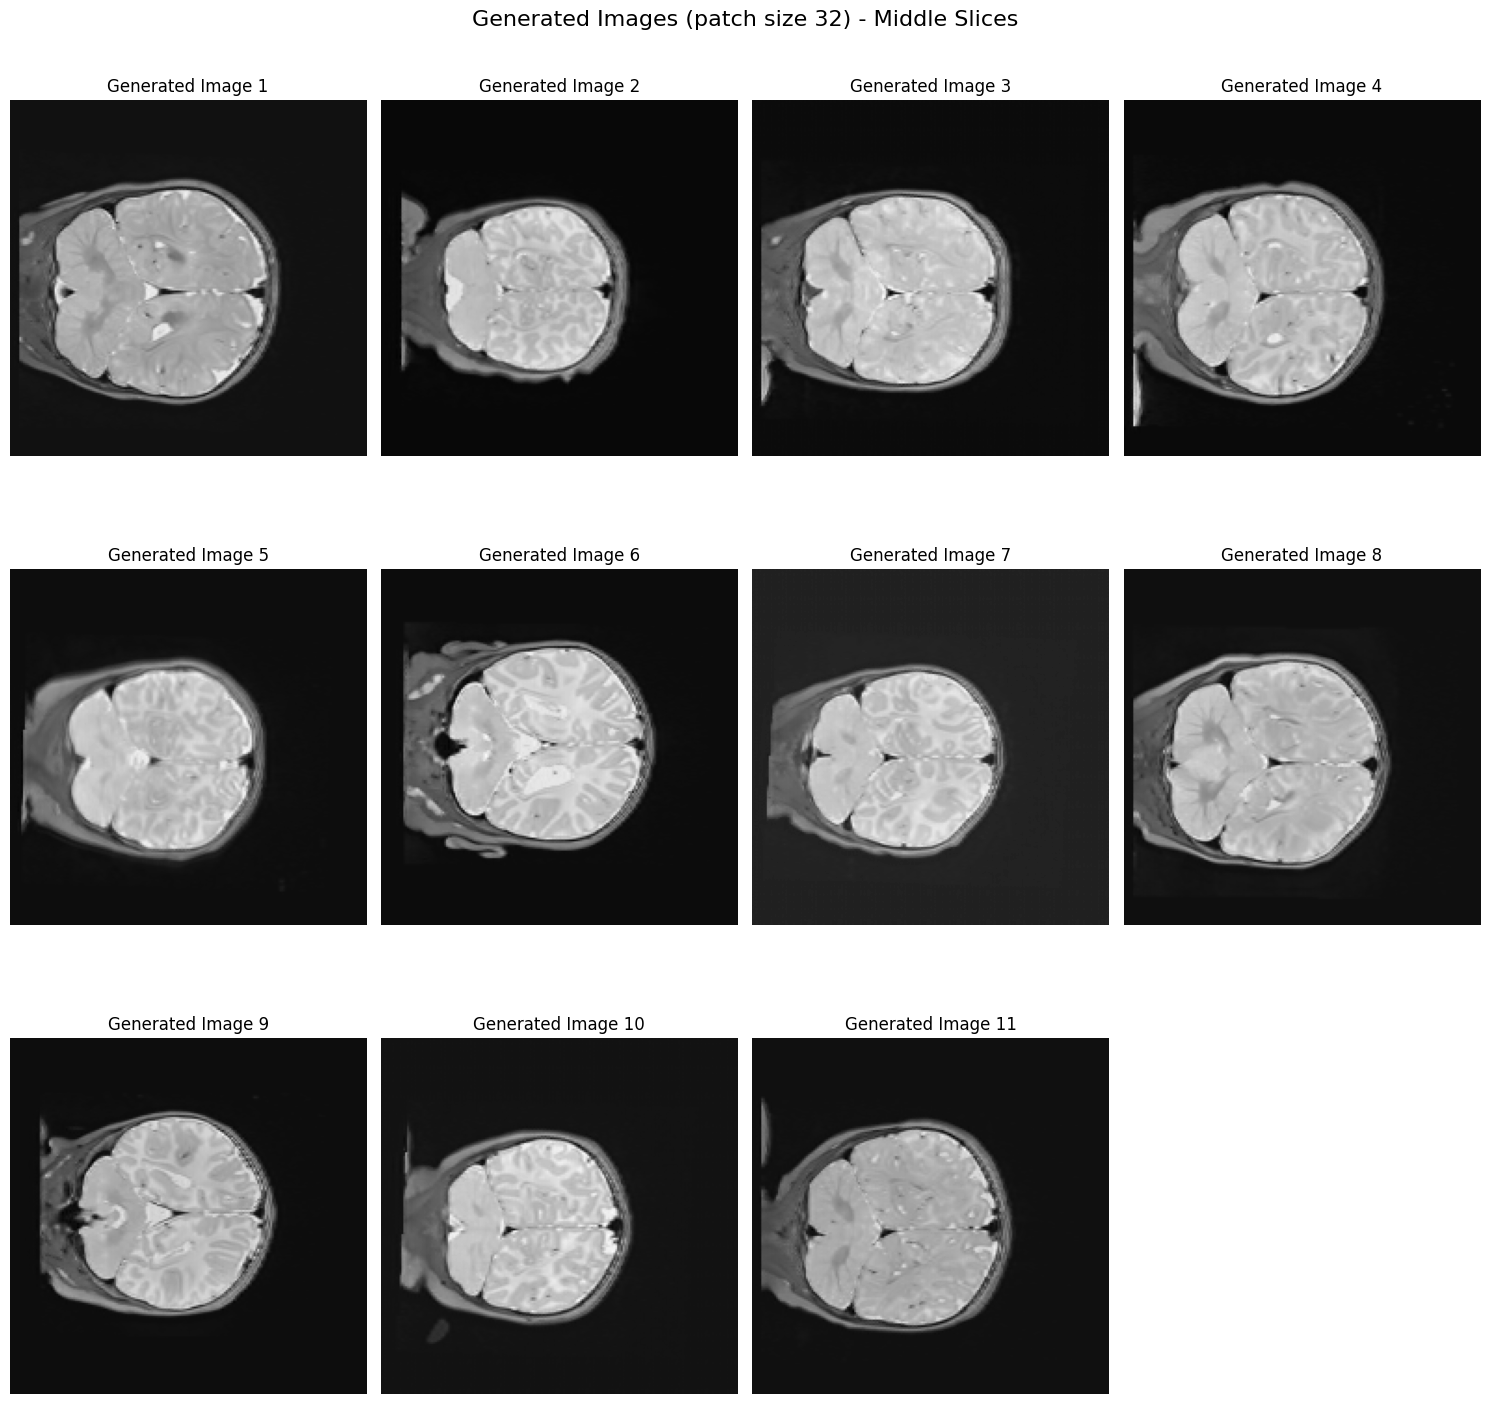

In [89]:

#plot the middle slice of all images in a grid
import matplotlib.pyplot as plt
import numpy as np
num_images = len(generated_images)
cols = 4
rows = num_images // cols + int(num_images % cols > 0)
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    mid_slice = generated_images[i].shape[2] // 2
    plt.imshow(generated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
plt.suptitle('Generated Images (patch size 32) - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()



In [21]:
#plot the middle slice of all images in a grid
import matplotlib.pyplot as plt
import numpy as np
num_images = len(real_images)
cols = 4
rows = num_images // cols + int(num_images % cols > 0)
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    mid_slice = real_images[i].shape[2] // 2
    plt.imshow(real_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Real Image {i+1}")
plt.suptitle('Real Images (reconstructed) - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()


<Figure size 1500x1500 with 0 Axes>

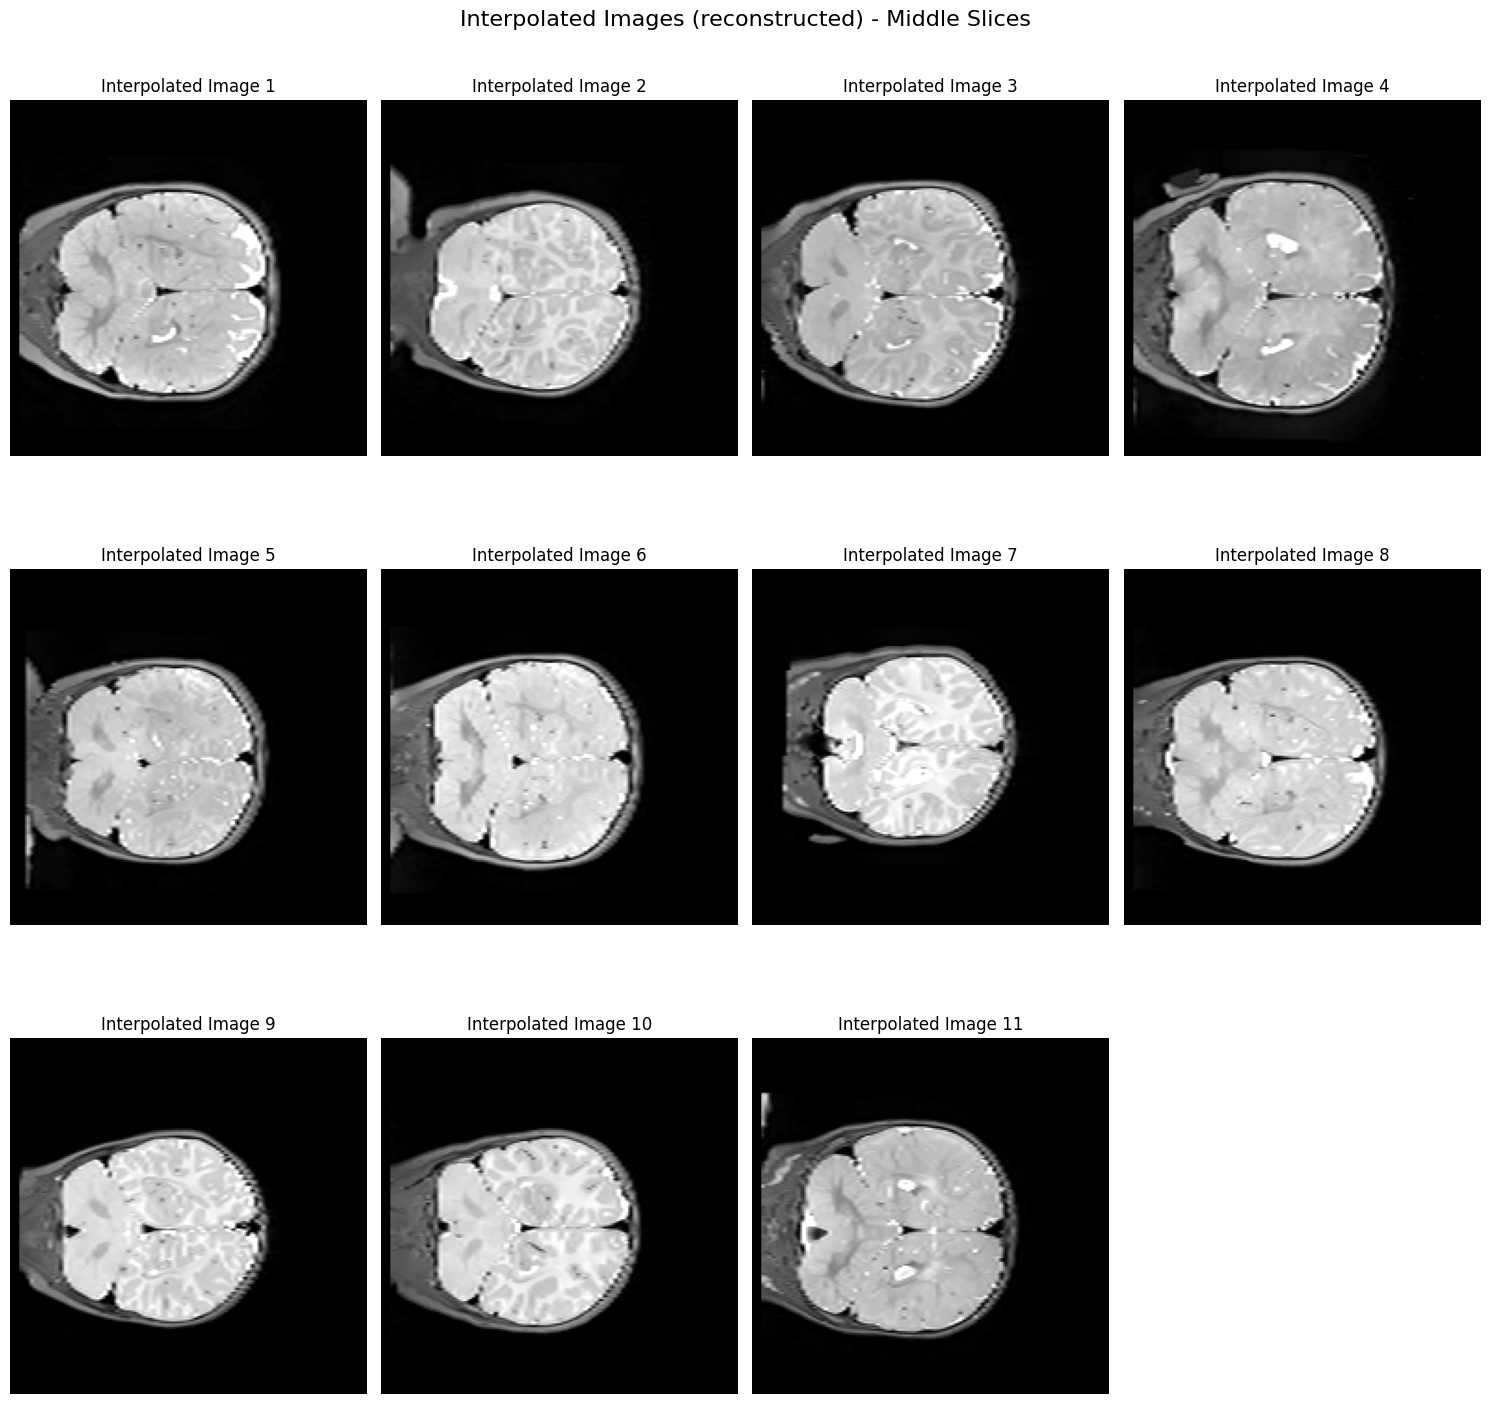

In [14]:
#plot the middle slice of all images in a grid
import matplotlib.pyplot as plt
import numpy as np
num_images = len(interpolated_images)
cols = 4
rows = num_images // cols + int(num_images % cols > 0)
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    mid_slice = interpolated_images[i].shape[2] // 2
    plt.imshow(interpolated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Interpolated Image {i+1}")
plt.suptitle('Interpolated Images (reconstructed) - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()



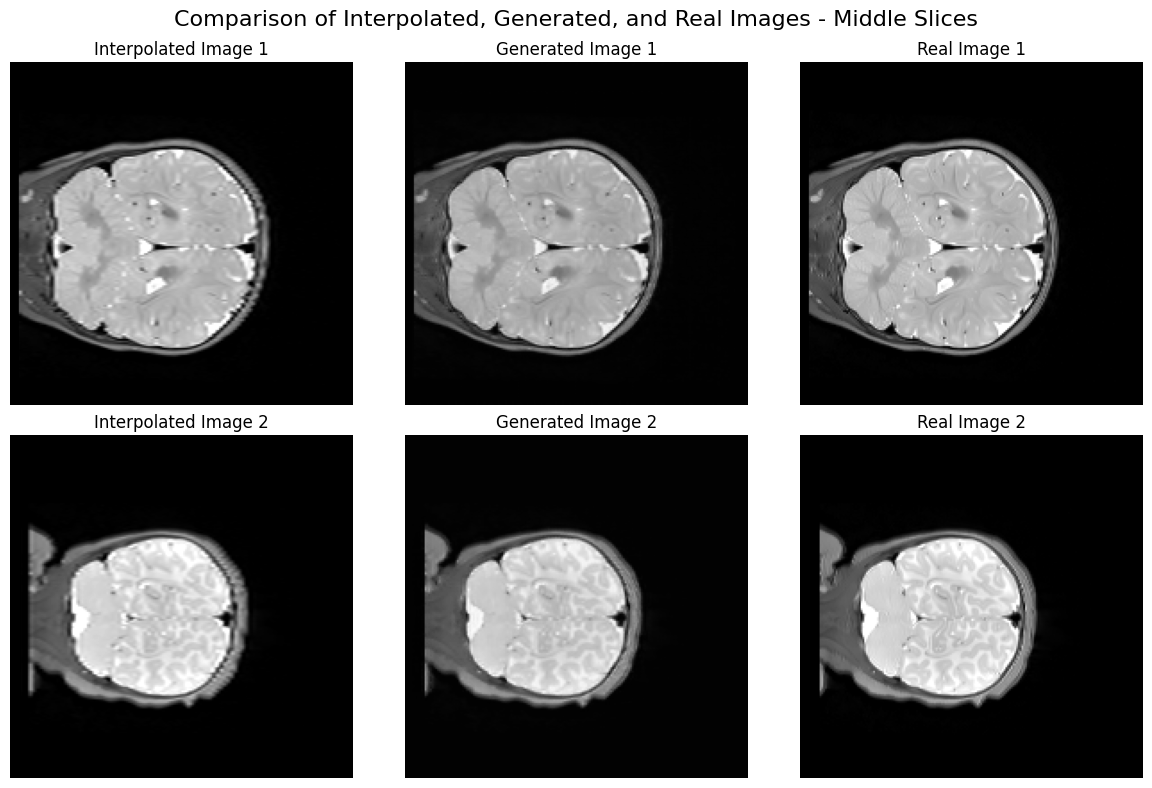

In [ ]:
#plot middle slice of interpolated_images, generated_images32 and real_images in a grid for comparison, first 2 images. image typs as columns, image index as rows
import matplotlib.pyplot as plt
import numpy as np
num_images = 2
cols = 3
rows = num_images
plt.figure(figsize=(12, 8))
for i in range(num_images):
    plt.subplot(rows, cols, i * cols + 1)
    mid_slice = interpolated_images[i].shape[2] // 2
    plt.imshow(interpolated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Interpolated Image {i+1}")
    
    plt.subplot(rows, cols, i * cols + 2)
    mid_slice = generated_images[i].shape[2] // 2
    plt.imshow(generated_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
    
    plt.subplot(rows, cols, i * cols + 3)
    mid_slice = real_images[i].shape[2] // 2
    plt.imshow(real_images[i][:, mid_slice, :], cmap='gray')
    plt.axis('off')
    plt.title(f"Real Image {i+1}")
plt.suptitle('Comparison of Interpolated, Generated, and Real Images - Middle Slices', fontsize=16)
plt.tight_layout()
plt.show()


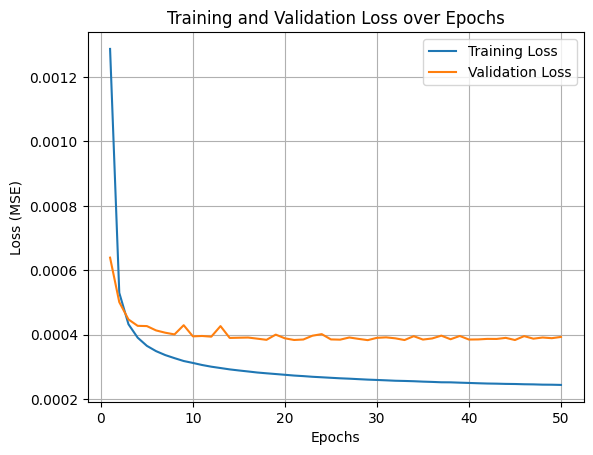

In [ ]:
#Plot a validation curve for loss and val_loss
import matplotlib.pyplot as plt
epochs = 50
val_loss_list = [0.0006390487498000999, 0.0005009573048477004, 0.0004470413742643986, 0.00042717746544239355, 0.0004264353254678675, 0.0004129404580365381, 0.0004058456909699314, 0.0004006056530541572, 0.0004291458396884013, 0.00039452219004629073, 0.00039569603874164993, 0.0003935613536135516, 0.00042641177299727054, 0.00038962099827324106, 0.0003902898701724109, 0.00039084918202226545, 0.00038735300323401934, 0.00038373461925623635, 0.00039991564295155537, 0.00038842282093681156, 0.00038327943966088375, 0.0003847624795749392, 0.0003966008611342398, 0.0004014271939556311, 0.00038502700879337274, 0.0003842632673505819, 0.0003910166242985975, 0.0003866973671873579, 0.0003827583612678102, 0.00038993398674081245, 0.0003914212029502318, 0.00038838330302293895, 0.00038310103810192787, 0.0003950606756922659, 0.00038454368062945947, 0.0003879984236388043, 0.00039671867463890703, 0.0003855478067123456, 0.00039572444207228695, 0.0003846537110360793, 0.0003850051885803981, 0.000386664208217803, 0.00038645431416123923, 0.00038983330121826563, 0.0003831572543678962, 0.0003952603362552435, 0.00038728921469673166, 0.00039093339816985634, 0.00038882977543382646, 0.0003927534394821874]
loss_list = [0.0012875754324046648, 0.0005297218698363672, 0.0004321094344799131, 0.00039044466105491647, 0.0003650201633322166, 0.0003485578383607857, 0.00033632625462282284, 0.0003268427853797054, 0.00031790949371926145, 0.0003119212911752412, 0.00030551510538857305, 0.0003002738362274099, 0.0002960998230692181, 0.00029189359236242847, 0.00028854170523145826, 0.0002854220648003036, 0.00028217007484859823, 0.0002797370006862376, 0.00027745036948611276, 0.00027511563527569884, 0.00027272248612196265, 0.00027100126413115406, 0.00026891505818420935, 0.0002673797497567201, 0.0002657637065372156, 0.00026420631379861953, 0.00026301752018092307, 0.00026154078953841977, 0.00026011676079859926, 0.0002590359671785839, 0.00025787847942664304, 0.00025659889124701545, 0.0002559605368797276, 0.0002551048706975876, 0.0002538699030300854, 0.00025298183556835663, 0.0002518438624401024, 0.0002516596256203837, 0.00025063612281259933, 0.0002497717765728877, 0.0002487980850088696, 0.00024797478494619017, 0.00024752888182889637, 0.00024682062522602706, 0.0002464761344886227, 0.00024570066353517516, 0.00024531482796820073, 0.0002444827827351382, 0.0002442700609044983, 0.00024363106217607737]
plt.plot(range(1, epochs + 1), loss_list, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



(192, 224, 192)


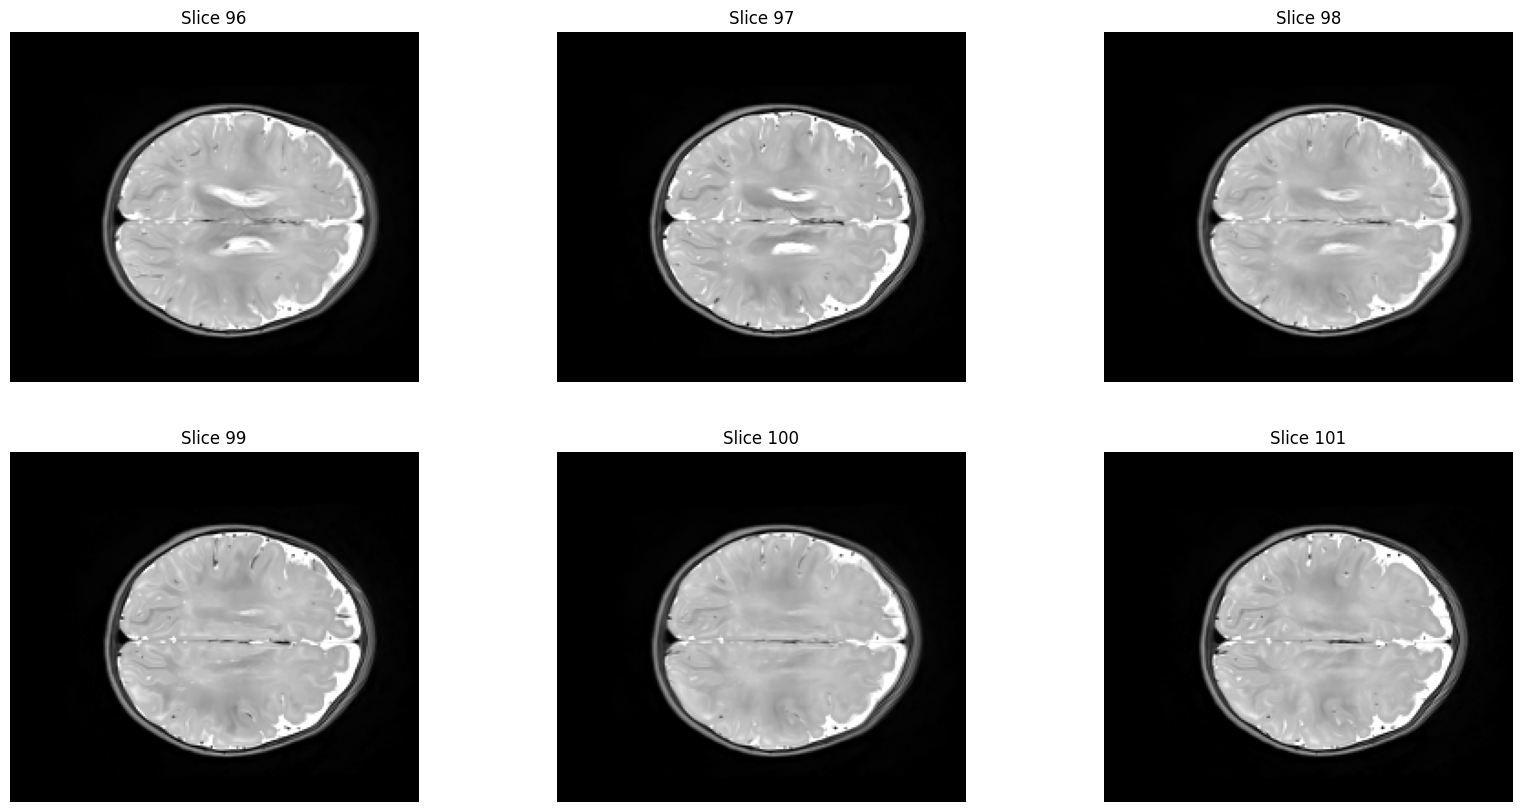

In [95]:
#Compare metrics between slices

print(generated_images[0].shape)

#show 6 slices in axial

plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    mid_slice = interpolated_images[0].shape[2] // 2
    plt.imshow(interpolated_images[0][:, :, mid_slice + i], cmap='gray')
    plt.axis('off')
    plt.title(f"Slice {mid_slice + i}")



In [79]:

#compare metrics between slice 97 and 98

inslice_metric = calculate_metrics([real_images[0][:, :, 97]], [generated_images[0][:, :, 97]])
betweenslice_metric = calculate_metrics([real_images[0][:, :, 98]], [generated_images[0][:, :, 98]])
print(f"Slice 97 - PSNR: {inslice_metric['psnr']}, SSIM: {inslice_metric['ssim']}, NRMSE: {inslice_metric['nrmse']}, MSE: {inslice_metric['mse']}")
print(f"Slice 98 - PSNR: {betweenslice_metric['psnr']}, SSIM: {betweenslice_metric['ssim']}, NRMSE: {betweenslice_metric['nrmse']}, MSE: {betweenslice_metric['mse']}")

inslice_interpolated = calculate_metrics([real_images[0][:, :, 97]], [interpolated_images[0][:, :, 97]])
betweenslice_interpolated = calculate_metrics([real_images[0][:, :, 98]], [interpolated_images[0][:, :, 98]])
print(f"Interpolated Slice 97 - PSNR: {inslice_interpolated['psnr']}, SSIM: {inslice_interpolated['ssim']}, NRMSE: {inslice_interpolated['nrmse']}, MSE: {inslice_interpolated['mse']}")
print(f"Interpolated Slice 98 - PSNR: {betweenslice_interpolated['psnr']}, SSIM: {betweenslice_interpolated['ssim']}, NRMSE: {betweenslice_interpolated['nrmse']},  MSE: {betweenslice_interpolated['mse']}")


Slice 97 - PSNR: 48.41427151551688, SSIM: 0.9986418798980666, NRMSE: 0.009394343614623053, MSE: 1.440697652244969e-05
Slice 98 - PSNR: 33.025286321482554, SSIM: 0.956545604121577, NRMSE: 0.05560772768443479, MSE: 0.000498277604462769
Interpolated Slice 97 - PSNR: 40.41999961280162, SSIM: 0.999684043581539, NRMSE: 0.02358196749230329, MSE: 9.078206111155851e-05
Interpolated Slice 98 - PSNR: 30.04818206057431, SSIM: 0.9325198220420122, NRMSE: 0.0783412256438995,  MSE: 0.000988966985670575


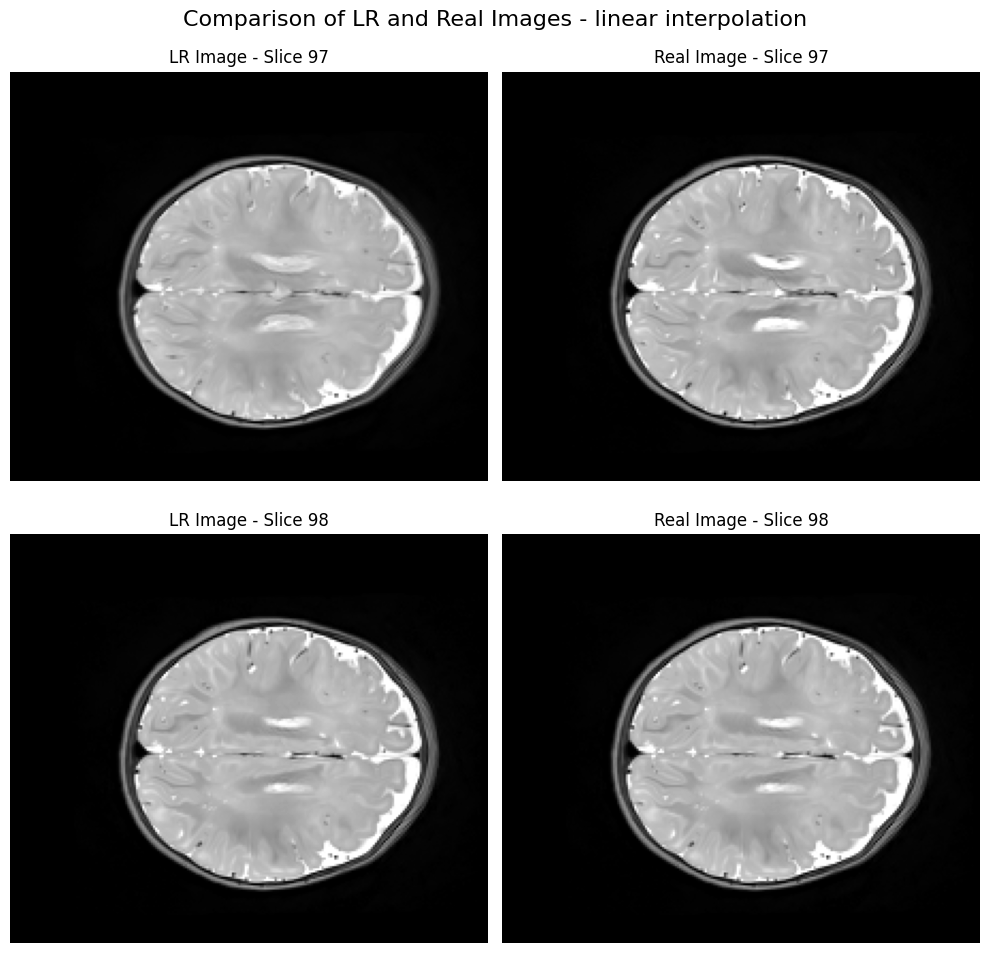

LR Slice 97 - PSNR: 29.994921962358077, SSIM: 0.9307630648573776, NRMSE: 0.07831301040823016, MSE: 0.0010011699452301883
LR Slice 98 - PSNR: inf, SSIM: 1.0, NRMSE: 0.0, MSE: 0.0


In [4]:
realimg = real_images[0]

lrimg = create_LR_img_simple(realimg, scale_factor=2)

import matplotlib.pyplot as plt
#plot slice 97 and 98 from realimg and lrimg
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)    
plt.imshow(lrimg[:, :, 97], cmap='gray')
plt.axis('off')
plt.title("LR Image - Slice 97")
plt.subplot(2, 2, 2)
plt.imshow(realimg[:, :, 97], cmap='gray')
plt.axis('off')
plt.title("Real Image - Slice 97")
plt.subplot(2, 2, 3)
plt.imshow(lrimg[:, :, 98], cmap='gray')
plt.axis('off')
plt.title("LR Image - Slice 98")
plt.subplot(2, 2, 4)
plt.imshow(realimg[:, :, 98], cmap='gray')
plt.axis('off')
plt.title("Real Image - Slice 98")
plt.suptitle('Comparison of LR and Real Images - linear interpolation', fontsize=16)
plt.tight_layout()
plt.show()

odd = calculate_metrics([realimg[:, :, 97]], [lrimg[:, :, 97]])
even = calculate_metrics([realimg[:, :, 98]], [lrimg[:, :, 98]])
print(f"LR Slice 97 - PSNR: {odd['psnr']}, SSIM: {odd['ssim']}, NRMSE: {odd['nrmse']}, MSE: {odd['mse']}")
print(f"LR Slice 98 - PSNR: {even['psnr']}, SSIM: {even['ssim']}, NRMSE: {even['nrmse']}, MSE: {even['mse']}")


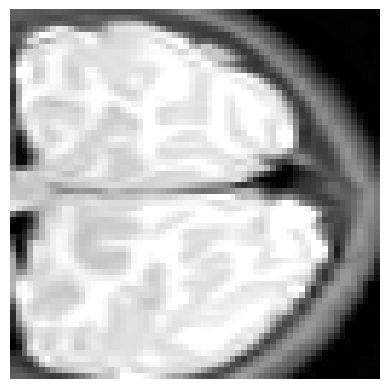

In [ ]:
#IMAGES FOR PP


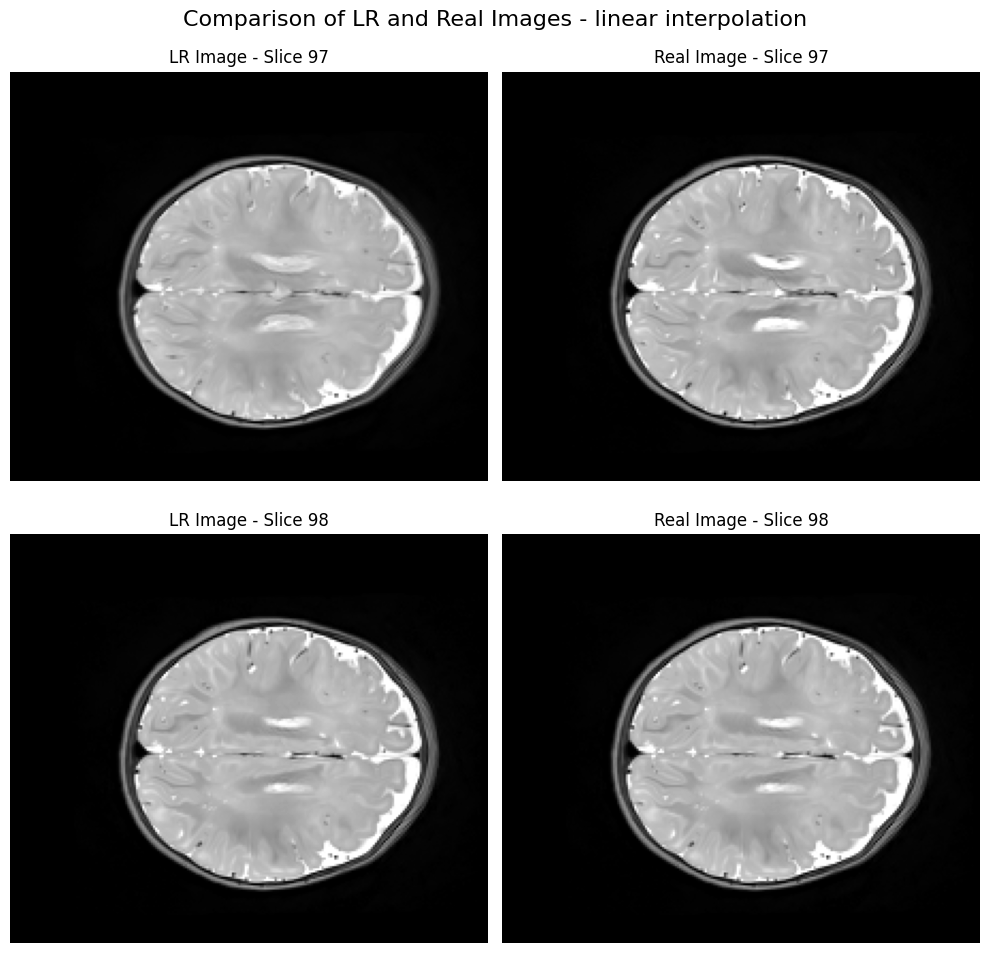

LR Slice 97 - PSNR: 29.994921962358077, SSIM: 0.9307630648573776, NRMSE: 0.07831301040823016, MSE: 0.0010011699452301883
LR Slice 98 - PSNR: inf, SSIM: 1.0, NRMSE: 0.0, MSE: 0.0


In [ ]:
realimg = real_images[0]

lrimg = create_LR_img_simple(realimg, scale_factor=2)

import matplotlib.pyplot as plt
#plot slice 97 and 98 from realimg and lrimg
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)    
plt.imshow(lrimg[:, :, 97], cmap='gray')
plt.axis('off')
plt.title("LR Image - Slice 97")
plt.subplot(2, 2, 2)
plt.imshow(realimg[:, :, 97], cmap='gray')
plt.axis('off')
plt.title("Real Image - Slice 97")
plt.subplot(2, 2, 3)
plt.imshow(lrimg[:, :, 98], cmap='gray')
plt.axis('off')
plt.title("LR Image - Slice 98")
plt.subplot(2, 2, 4)
plt.imshow(realimg[:, :, 98], cmap='gray')
plt.axis('off')
plt.title("Real Image - Slice 98")
plt.suptitle('Comparison of LR and Real Images - linear interpolation', fontsize=16)
plt.tight_layout()
plt.show()

odd = calculate_metrics([realimg[:, :, 97]], [lrimg[:, :, 97]])
even = calculate_metrics([realimg[:, :, 98]], [lrimg[:, :, 98]])
print(f"LR Slice 97 - PSNR: {odd['psnr']}, SSIM: {odd['ssim']}, NRMSE: {odd['nrmse']}, MSE: {odd['mse']}")
print(f"LR Slice 98 - PSNR: {even['psnr']}, SSIM: {even['ssim']}, NRMSE: {even['nrmse']}, MSE: {even['mse']}")


In [ ]:
#create simple interpolation LR images for the whole dataset
for i in range(len(t2_files)):
    t2_img = nib.load(t2_files[i]).get_fdata()
    t2_LR_img = create_LR_img_simple(t2_img, scale_factor=2)
    #save t2_LR_img as nii.gz
    t2_LR_nifti = nib.Nifti1Image(t2_LR_img, affine=nib.load(t2_files[i]).affine)
    #extract filename without suffix
    t2_LR_filename = t2_files[i].name.split(".")[0]
    nib.save(t2_LR_nifti, DATA_DIR / "simple_LR" / f"{t2_LR_filename}_simple_LR.nii.gz")


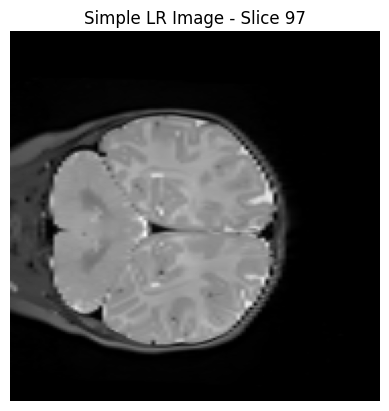

In [ ]:

t2_simple_LR_files = sorted((DATA_DIR / "simple_LR").rglob("*T2w_simple_LR.nii.gz"))
hej = nib.load(t2_simple_LR_files[0]).get_fdata()
plt.imshow(hej[:, 97, :], cmap='gray')
plt.axis('off')
plt.title("Simple LR Image - Slice 97")
plt.show()



In [ ]:
#calculate metrics between generated and real images
metrics = calculate_metrics(real_images, generated_images)
print(f"Generated - PSNR: {metrics['psnr']}, SSIM: {metrics['ssim']}, NRMSE: {metrics['nrmse']}, MSE: {metrics['mse']}")



Generated - PSNR: 33.402482479633946, SSIM: 0.9833514485329368, NRMSE: 0.0808868339780555, MSE: 0.000465945677273482


In [101]:
#create nifti generated images
for i in range(len(generated_images)):
    gen_nifti = nib.Nifti1Image(generated_images[i], affine=nib.load(test[i][1]).affine)
    t2_filename = test[i][1].name.split(".")[0]
    nib.save(gen_nifti, DATA_DIR / "generated_images" / f"{t2_filename}_generated.nii.gz")